In [99]:
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline 

In [100]:
df = pd.read_csv('data/edges.csv', usecols=[1, 2])
df[['source', 'target']] = df['edge'].str.split(' ', n=1, expand=True)
df.tail()

,edge,count,source,target
466444,zizu232 fancybeekeeper,1,zizu232,fancybeekeeper
466445,znslattt fatafata12,1,znslattt,fatafata12
466446,zoinks27 ravenpvff,1,zoinks27,ravenpvff
466447,zu_capone kukdraws,1,zu_capone,kukdraws
466448,zuqwaylh Kythoarr,1,zuqwaylh,Kythoarr


In [101]:
df_class = pd.read_csv('data/author_class.csv', usecols=[1, 3])
flags = df_class.set_index('author')['i_or_e'].to_dict()

In [102]:
# Create multi directed graph
Graphtype = nx.MultiDiGraph()
G = nx.from_pandas_edgelist(df,source = 'source', target = 'target', edge_key='count', create_using=Graphtype)
nx.set_node_attributes(G, flags, "flag")    # add flag to graph

In [103]:
H = nx.MultiGraph(G)     # unweighted undirected version

In [104]:
N = G.number_of_nodes()
N

26809

In [105]:
L=G.number_of_edges()
L

466449

In [106]:
H.number_of_edges()

367695

In [107]:
# Initialize counters for edges within and between classes
within_class_E = 0
within_class_I = 0
between_classes = 0

# Count the edges
for u, v in G.edges():
    if G.nodes[u]['flag'] == G.nodes[v]['flag']:
        if G.nodes[u]['flag'] == 'e':
            within_class_E += 1
        else:
            within_class_I += 1
    else:
        between_classes += 1

In [108]:
print(within_class_I, within_class_E, between_classes)
print(within_class_I + within_class_E + between_classes)

229092 52181 185176
466449


In [109]:
tot_i = 18999
tot_e =7810

In [110]:
# homopily scores
p =2*L/(N*(N-1))
m_ee = L* tot_e*(tot_e-1)/(N*(N-1))
m_ii = L* tot_i*(tot_i-1)/(N*(N-1))
m_ie = L*tot_i*tot_e/(N*(N-1))

m_ee = tot_e*(tot_e-1)*p/2
m_ii = tot_i*(tot_i-1)*p/2
m_ie = tot_i*tot_e*p


print(f'i: {within_class_I/m_ii}, e: {within_class_E/m_ee}, ei:{between_classes/m_ie}')

i: 0.9779398888792533, e: 1.3182773920894795, ei:0.9614214106260967


## Degree distribution analysis

In [111]:
# Average degree
sum(dict(G.degree()).values())/float(len(G))

34.79794098996606

In [112]:
# Average degree
sum(dict(H.degree()).values())/float(len(H))

27.430713566339662

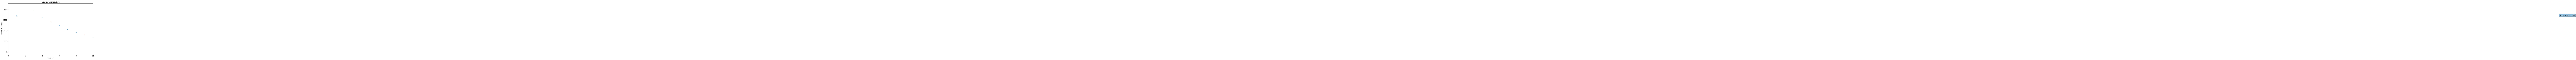

In [113]:
hist_g = nx.degree_histogram(G)

plt.figure(figsize = (10,6))
plt.plot(range(0, len(hist_g)), hist_g, ".")
plt.text(300, 1700, 'Avg degree = 27.43', fontsize=10, bbox=dict( alpha=0.5))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("number of Nodes")
plt.xlim(0,10)
#plt.loglog()
plt.show()

In [114]:
def plot_dist(G):
    M = nx.to_scipy_sparse_array(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).flatten()
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS', xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    fig = plt.figure(figsize=(16, 6)) 
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()
    return fit

In [115]:
def plot_dist(G):
    M = nx.to_scipy_sparse_array(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).flatten()
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS', xmin=xmin, xmax=max(degree)-xmin, discrete=True)
    
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    ks = fit.power_law.KS()
    print(ks)
    
    fig = plt.figure(figsize=(16, 6)) 
    
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)), degree, 'b.')   
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit')
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.title(f'Power Law Fit\nalpha={alpha:.2f}, sigma={sigma:.2f}')

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')
    plt.title(f'CDF\nalpha={alpha:.2f}, sigma={sigma:.2f}')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.title(f'CCDF\nalpha={alpha:.2f}, sigma={sigma:.2f}')
    
    plt.show()

0.048278071723506066


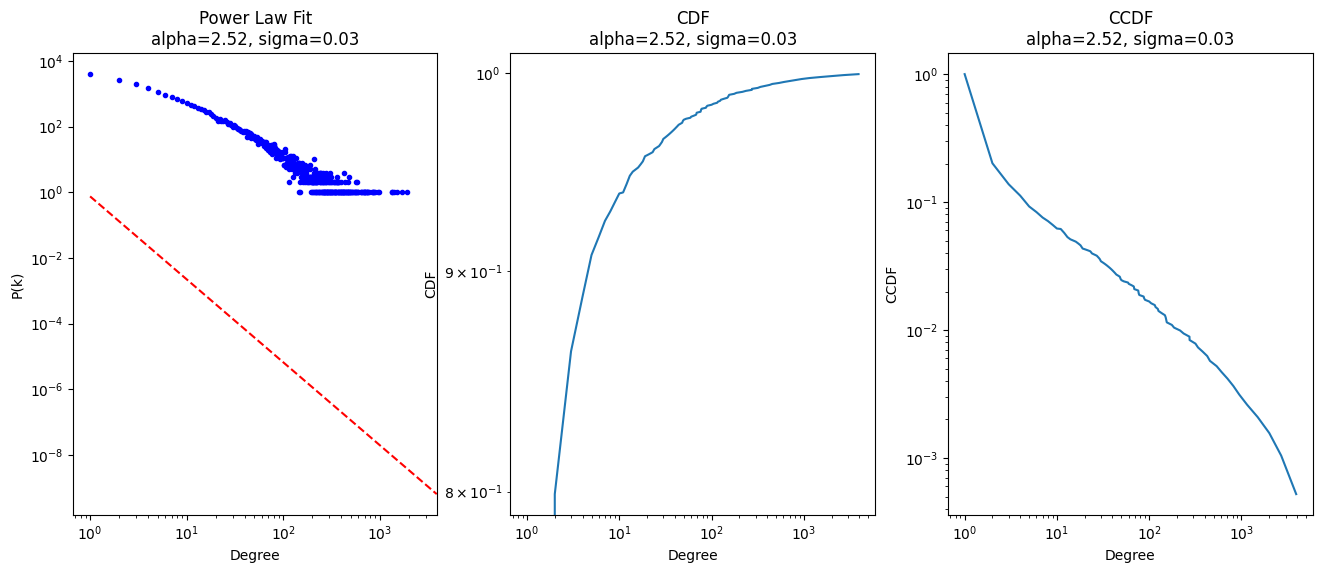

In [116]:
fit = plot_dist(G)

In [117]:
# Average in degree
sum(dict(G.in_degree()).values())/float(len(G))

17.39897049498303

In [118]:
# Average out degree
sum(dict(G.out_degree()).values())/float(len(G))

17.39897049498303

## Connected components analysis

In [119]:
nx.number_connected_components(H)

1

In [120]:
# Diameter for the giant (and only) component
comps = list(nx.connected_components(H))
#nx.diameter(H.subgraph(comps[0]))   #Ci impiega una vita -.-

In [121]:
nx.density(H)

0.001023228646909119

In [123]:
nx.average_clustering(H)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ks/5_cxdzt52gz2lghcr64x80zm0000gn/T/ipykernel_53147/2547990637.py", line 1, in <module>
    nx.average_clustering(H)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/utils/backends.py", line 412, in __call__
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/cluster.py", line 306, in average_clustering
    The value of :math:`c_u` is assigned to 0 if :math:`deg(u) < 2`.
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/utils/backends.py", line 412, in __call__
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/cluster.py", line 4

## ER graph

In [124]:
er = nx.erdos_renyi_graph(26800, 0.001)

In [125]:
er.number_of_nodes()

26800

In [126]:
2*367695/(26800**2)

0.0010238778124303854

In [127]:
er.number_of_edges()

359177

In [128]:
nx.density(er)

0.0010001960420666176

In [129]:
nx.number_connected_components(er)

1

In [130]:
nx.average_clustering(er)

0.0009755683542375302

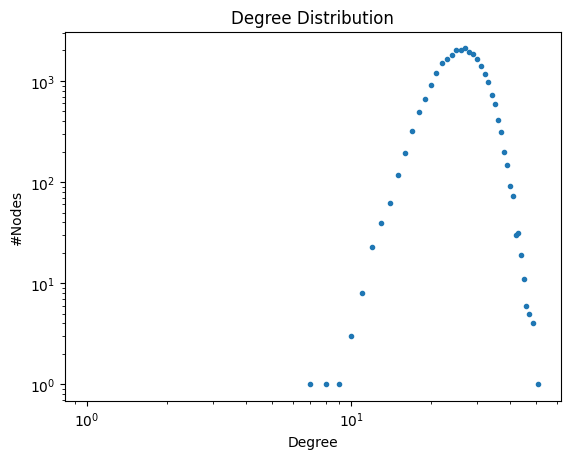

In [131]:
hist_er = nx.degree_histogram(er)

plt.plot(range(0, len(hist_er)), hist_er, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [132]:
# Average degree
sum(dict(er.degree()).values())/float(len(er))

26.804253731343284

In [133]:
np.log(er.number_of_nodes())

10.196157166498947

=> supercritical regime

## BA graph

In [134]:
m = 14  # number of links each node establishes once joining the network
ba = nx.barabasi_albert_graph(26800, m)

In [135]:
367695/26800

13.719962686567165

In [136]:
ba.number_of_nodes()

26800

In [137]:
ba.number_of_edges()

375004

In [138]:
nx.number_connected_components(ba)

1

In [139]:
nx.density(ba)

0.0010442693061057636

In [140]:
nx.average_clustering(ba)

0.006530230998446549

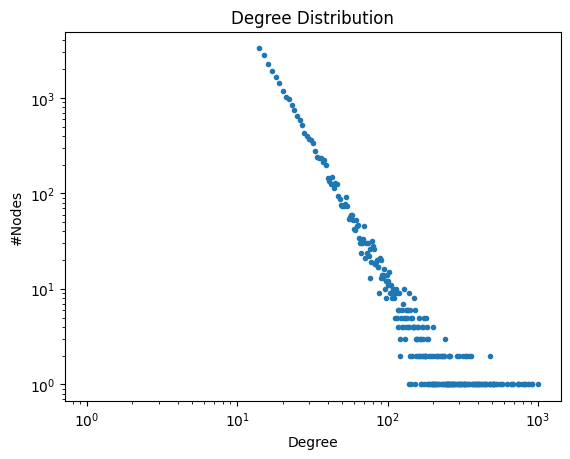

In [141]:
hist_ba = nx.degree_histogram(ba)

plt.plot(range(0, len(hist_ba)), hist_ba, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [142]:
# Average degree
sum(dict(ba.degree()).values())/float(len(ba))

27.98537313432836

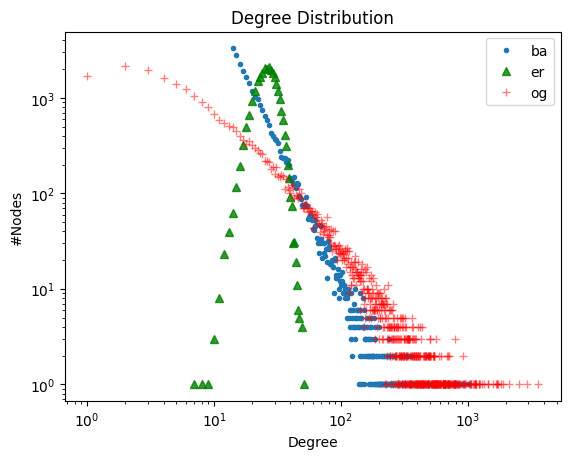

In [148]:
plt.plot(range(0, len(hist_ba)), hist_ba, ".", label = 'ba')
plt.plot(range(0, len(hist_er)), hist_er, "^", color ='g', label = 'er', alpha = 0.8)
plt.plot(range(0, len(hist_g)), hist_g, "+", color = 'r', label = 'og', alpha = 0.5)
plt.legend()
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

|          | Original | ER     |  BA  |
| -------- | -------  | ------ |------|
| `N`      | 32724    |  32700 |32700 |
| `L`      | 485822   | 48212  |490275|
| `<k>  `  | 29.69     | 2.95   | 30.00 |

## Centrality

In [144]:
closeness = nx.closeness_centrality(H)

KeyboardInterrupt: 

In [ ]:
plt.hist(closeness.values(), bins = 50)
plt.title('Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.ylabel('Number of Nodes')

In [ ]:
betweenness = nx.betweenness_centrality(H)

In [ ]:
plt.hist(betweenness.values(), bins = 50)
plt.title('Betweenness Centrality')
plt.yscale('log')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Number of Nodes')

In [ ]:
harmonic = nx.harmonic_centrality(H)

In [ ]:
eigen = nx.eigenvector_centrality(H)

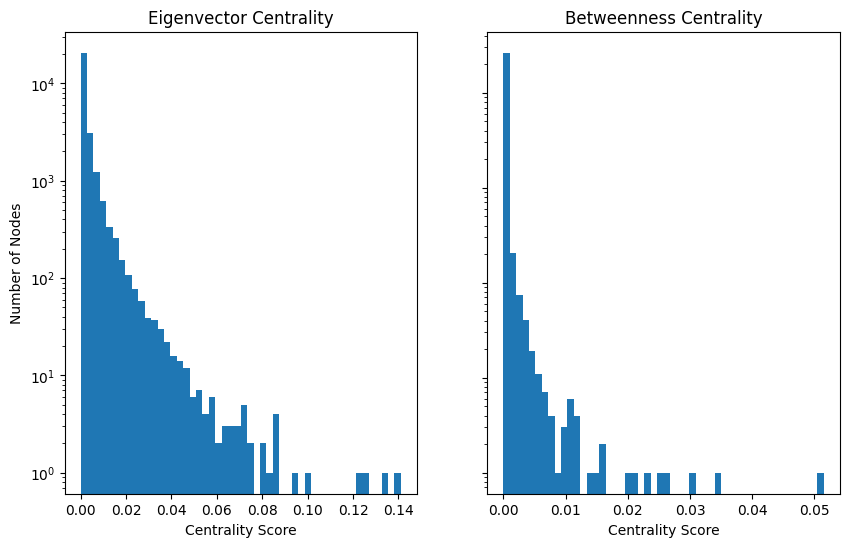

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].hist(eigen.values(), bins = 50)
axs[0].set_title('Eigenvector Centrality')
axs[0].set_yscale('log')
axs[1].hist(betweenness.values(), bins = 50)
axs[1].set_title('Betweenness Centrality')
axs[1].set_yscale('log')

for ax in axs.flat:
    ax.set(xlabel='Centrality Score', ylabel='Number of Nodes')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

axs.flat

In [ ]:
merged_dict = {key: {'flag': flags[key], 'eigen': eigen[key], 'btw': betweenness[key]} for key in G.nodes()}

In [ ]:
df = pd.DataFrame.from_dict(merged_dict)
df = df.T
df.head()

,flag,eigen,btw
--------_--,e,0.000724,0.000001
Juulsteen,e,0.006731,0.00006
1Zer0Her0,e,0.008486,0.000179
5wings4birds,i,0.04993,0.003857
Ak_707,i,0.002139,0.000009


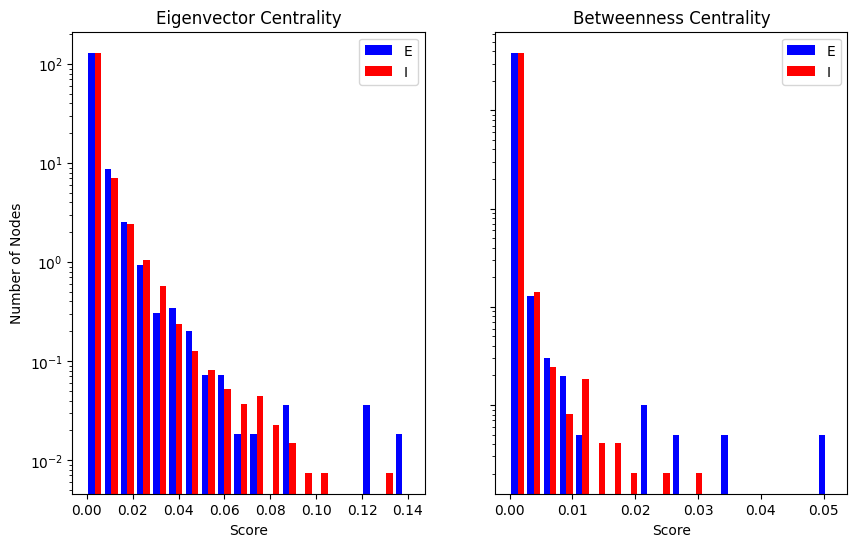

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(10,6))

# Separate the centrality values based on the flag
eigen_e = [info['eigen'] for info in merged_dict.values() if info['flag'] == 'e']
eigen_i = [info['eigen'] for info in merged_dict.values() if info['flag'] == 'i']
btw_e = [info['btw'] for info in merged_dict.values() if info['flag'] == 'e']
btw_i = [info['btw'] for info in merged_dict.values() if info['flag'] == 'i']

fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].hist([eigen_e, eigen_i], bins=20, stacked=False, 
            density=True, color=['blue', 'red'], label=['E', 'I'])
axs[0].set_title('Eigenvector Centrality')
axs[0].set_yscale('log')
axs[1].hist([btw_e, btw_i], bins=20, stacked=False, 
            density=True, color=['blue', 'red'], label=['E', 'I'])
axs[1].set_title('Betweenness Centrality')
axs[1].set_yscale('log')
axs[0].legend()
axs[1].legend()


for ax in axs.flat:
    ax.set(xlabel='Score', ylabel='Number of Nodes')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

axs.flat

In [ ]:
in_deg = dict(G.in_degree())
in_deg = {key: {'in_deg': in_deg[key], 'flag': flags[key]} for key in in_deg}
out_deg = dict(G.out_degree())
out_deg = {key: {'out_deg': out_deg[key], 'flag': flags[key]} for key in out_deg}

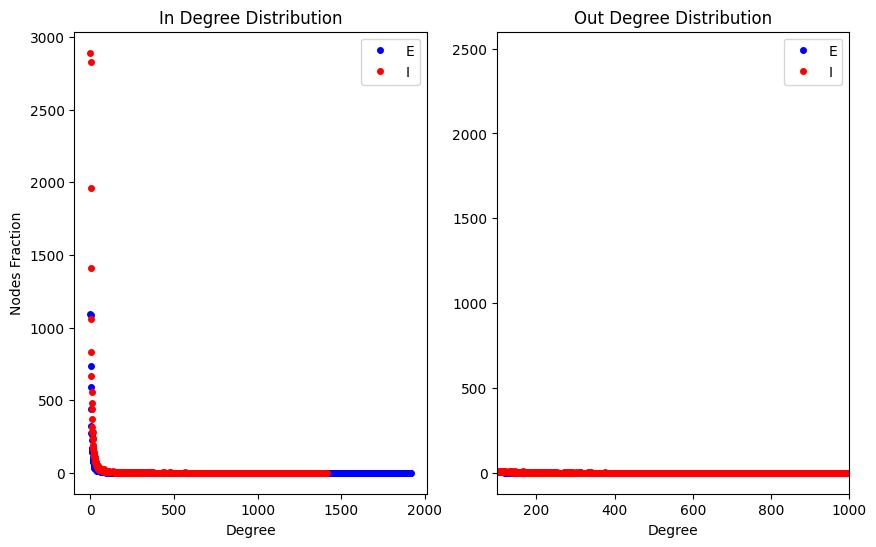

In [ ]:
# Extract the degree values
in_degrees_e = [info['in_deg'] for info in in_deg.values() if info['flag'] == 'e']
in_degrees_i = [info['in_deg'] for info in in_deg.values() if info['flag'] == 'i']
out_degrees_e = [info['out_deg'] for info in out_deg.values() if info['flag'] == 'e']
out_degrees_i = [info['out_deg'] for info in out_deg.values() if info['flag'] == 'i']


# Calculate the degree histogram (degree distribution)
in_degree_count_e = Counter(in_degrees_e)
in_degree_count_i = Counter(in_degrees_i)
out_degree_count_e = Counter(out_degrees_e)
out_degree_count_i = Counter(out_degrees_i)


# Normalisation
tot_i = 18999
tot_e =7810

in_degree_hist_e = [in_degree_count_e.get(i, 0) for i in range(max(in_degrees_e) + 1)]
in_degree_hist_e = np.array(in_degree_hist_e) #/ tot_e
in_degree_hist_i = [in_degree_count_i.get(i, 0) for i in range(max(in_degrees_i) + 1)]
in_degree_hist_i = np.array(in_degree_hist_i) #/ tot_i
out_degree_hist_e = [out_degree_count_e.get(i, 0) for i in range(max(out_degrees_e) + 1)]
out_degree_hist_e = np.array(out_degree_hist_e) #/ tot_e
out_degree_hist_i = [out_degree_count_i.get(i, 0) for i in range(max(out_degrees_i) + 1)]
out_degree_hist_i = np.array(out_degree_hist_i) #/ tot_i

# Plot the degree distribution
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 6))
ax1.plot(range(len(in_degree_hist_e)), in_degree_hist_e, ".", markersize=8, label='E', color='blue')
ax1.plot(range(len(in_degree_hist_i)), in_degree_hist_i, ".", markersize=8, label='I', color='red')
ax2.plot(range(len(out_degree_hist_e)), out_degree_hist_e, ".", markersize=8, label='E', color='blue')
ax2.plot(range(len(out_degree_hist_i)), out_degree_hist_i, ".", markersize=8, label='I', color='red')

# Adding titles and labels
ax1.set_title("In Degree Distribution")
ax2.set_title("Out Degree Distribution")
ax1.set_xlabel("Degree")
ax2.set_xlabel("Degree")
ax1.set_ylabel("Nodes Fraction")
ax1.legend()
ax2.legend()

# Set log-log scale
ax1.loglog()
ax2.loglog()


# Show the plot
plt.show()

In [ ]:
out_degrees_e.sort()
out_degrees_e

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
print(np.mean(in_degrees_e))
print(np.mean(in_degrees_i))
print(np.mean(out_degrees_e))
print(np.mean(out_degrees_i))

18.786683738796416
16.828517290383704
18.286043533930858
17.03431759566293
